# New Project Pivot:

Description: Weather app + predictors based on climate change history

My part: making visualizations based on previous weather data from Nasa API


In [1]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
import plotly.graph_objs as go
import matplotlib.dates as mdates
# ML libraries - idk which one to use yet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import cKDTree


In [2]:
import requests
import pandas as pd

def get_nasa_power_hourly_data(lat, lon, start_date, end_date, query_datetime=None):
    """
    Fetches hourly NASA POWER API data for a given latitude, longitude, and time range.
    Allows filtering by specific date and time.

    Args:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - start_date (str): Start date in YYYYMMDD format.
    - end_date (str): End date in YYYYMMDD format.
    - query_datetime (str, optional): Specific datetime to filter (format: "YYYY-MM-DD HH:00").

    Returns:
    - Pandas DataFrame with selected weather parameters.
    - If query_datetime is provided, returns only the row matching that datetime.
    """

    # Specify parameters to fetch
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M"

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"  # Change to hourly

    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        return None

    data = response.json()

    # Convert JSON response to DataFrame and transpose it
    nasa_weather = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T

    # Reset index and rename date column
    nasa_weather.reset_index(inplace=True)
    nasa_weather.rename(columns={"index": "datetime"}, inplace=True)

    # Convert datetime column to proper datetime format
    nasa_weather["datetime"] = pd.to_datetime(nasa_weather["datetime"], format="%Y%m%d%H", errors="coerce")
    nasa_weather.dropna(subset=["datetime"], inplace=True)  # Remove invalid date rows

    nasa_weather.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m"
    }, inplace=True)
    
    # Add Rounded_Lat and Rounded_Lng for merging
    nasa_weather['Rounded_Lat'] = lat
    nasa_weather['Rounded_Lng'] = lon

    # Convert units
    nasa_weather['Precipitation(in)'] = nasa_weather['Total_Precipitation_mm'] / 25.4  # mm to in
    nasa_weather['Temperature(F)'] = (nasa_weather['Temperature_2m_C'] * 9/5) + 32  # C to F
    nasa_weather['Wind_Speed(mph)'] = nasa_weather['Wind_Speed_2m'] * 2.237  # m/s to mph

    if query_datetime:
        query_datetime = pd.to_datetime(query_datetime, format="%Y-%m-%d %H:%M", errors="coerce")
        filtered_data = nasa_weather[nasa_weather["datetime"] == query_datetime]
        
        if filtered_data.empty:
            print(f"No data found for {query_datetime}. Try a different date/time within range.")
            return None
        
        print(f"\nWeather Data for {query_datetime} at Latitude {lat}, Longitude {lon}\n")
        return filtered_data

    print(f"\nHourly Weather Data for Latitude {lat}, Longitude {lon}\n")
    
    # Add Lat/Lon
    nasa_weather['Latitude'] = lat
    nasa_weather['Longitude'] = lon
    
    return nasa_weather


In [3]:
# Example: Fetch data for different locations
# by the day (hourly)
get_nasa_power_hourly_data(lat=37.7749, lon=-122.4194, start_date="20240225", end_date="20240226")


Hourly Weather Data for Latitude 37.7749, Longitude -122.4194



,datetime,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph),Latitude,Longitude
0,2024-02-25 00:00:00,0.0,10.50,0.06,12.42,1.18,37.7749,-122.4194,0.002362,54.356,2.63966,37.7749,-122.4194
1,2024-02-25 01:00:00,0.0,10.71,0.11,11.74,1.40,37.7749,-122.4194,0.004331,53.132,3.13180,37.7749,-122.4194
2,2024-02-25 02:00:00,0.0,10.77,0.11,10.94,1.59,37.7749,-122.4194,0.004331,51.692,3.55683,37.7749,-122.4194
3,2024-02-25 03:00:00,0.0,10.73,0.08,10.41,1.72,37.7749,-122.4194,0.003150,50.738,3.84764,37.7749,-122.4194
4,2024-02-25 04:00:00,0.0,10.67,0.10,10.17,1.73,37.7749,-122.4194,0.003937,50.306,3.87001,37.7749,-122.4194
5,2024-02-25 05:00:00,0.0,10.59,0.10,10.13,1.61,37.7749,-122.4194,0.003937,50.234,3.60157,37.7749,-122.4194
6,2024-02-25 06:00:00,0.0,10.50,0.07,10.27,1.42,37.7749,-122.4194,0.002756,50.486,3.17654,37.7749,-122.4194
7,2024-02-25 07:00:00,0.0,10.85,0.07,11.20,1.07,37.7749,-122.4194,0.002756,52.160,2.39359,37.7749,-122.4194
8,2024-02-25 08:00:00,0.0,11.18,0.03,13.03,1.10,37.7749,-122.4194,0.001181,55.454,2.46070,37.7749,-122.4194
9,2024-02-25 09:00:00,0.0,10.45,0.00,14.46,1.37,37.7749,-122.4194,0.000000,58.028,3.06469,37.7749,-122.4194


In [4]:
# by specific hours
get_nasa_power_hourly_data(lat=37.7749, lon=-122.4194, start_date="20240225", end_date="20240226", query_datetime="2024-02-25 14:00")



Weather Data for 2024-02-25 14:00:00 at Latitude 37.7749, Longitude -122.4194



,datetime,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph)
14,2024-02-25 14:00:00,0.0,9.08,0.0,16.15,2.15,37.7749,-122.4194,0.0,61.07,4.80955


# Making visualizations

Ideas?
- general weather data (look at weather apps available)
- hourly + daily updates?
- data on each from past 10 years (mean of each year?)
- making a heat map based on surrounding area? (Temp + Precipitation)

In [5]:
def plot_hourly_temperature(df):
    """
    Plot temperature trends over time.
    Args:
        df: the dataframe from the NASA API call
    """
    fig = px.line(df, 
                  x="datetime", 
                  y="Temperature(F)", 
                  title="Temperature(F)",
                  labels={"datetime": "Datetime", "Temperature(F)": "Temperature (°F)"},
                  line_shape='linear', 
                  color_discrete_sequence=['red'])
    
    fig.update_layout(xaxis_title="Datetime", 
                      yaxis_title="Temperature (°F)", 
                      xaxis_tickangle=-45)
    fig.show()

In [6]:
def plot_hourly_precipitation(df):
    """
    Plot precipitation trends over time.
    Args:
        df: the dataframe from the NASA API call
    """
    fig = px.line(df, 
                  x="datetime", 
                  y="Precipitation(in)", 
                  title="Hourly Precipitation Trends",
                  labels={"datetime": "Datetime", "Precipitation(in)": "Total Precipitation (in)"},
                  line_shape='linear', 
                  color_discrete_sequence=['blue'])
    
    fig.update_layout(xaxis_title="Datetime", 
                      yaxis_title="Precipitation(in)", 
                      xaxis_tickangle=-45)
    fig.show()


In [7]:
def plot_hourly_wind_speed(df):
    """
    Plot wind speed trends over time.
    Args:
        df: the dataframe from the NASA API call
    """
    fig = px.line(df, 
                  x="datetime", 
                  y="Wind_Speed(mph)", 
                  title="Hourly Wind Speed Trends",
                  labels={"datetime": "Datetime", "Wind_Speed(mph)": "Wind Speed (m/h)"},
                  line_shape='linear', 
                  color_discrete_sequence=['blue'])
    
    fig.update_layout(xaxis_title="Datetime", 
                      yaxis_title="Wind Speed (m/h)", 
                      xaxis_tickangle=-45)
    fig.show()

In [8]:
def get_nasa_power_data_for_ten_years(lat, lon, start_year, end_year):
    """
    Fetches NASA POWER API hourly data for a ten-year period by splitting requests into two-year intervals.
    This is because it times out if you try to get too many years at one time
    """
    all_data = []
    for year in range(start_year, end_year, 2):
        start_date = f"{year}0101"
        end_date = f"{min(year + 1, end_year)}1231"
        print(f"Fetching data from {start_date} to {end_date}")
        df = get_nasa_power_hourly_data(lat, lon, start_date, end_date)
        if df is not None:
            all_data.append(df)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("No data retrieved for the specified range.")
        return None

# Example call for ten years of data
data_ten_years = get_nasa_power_data_for_ten_years(37.7749, -122.4194, 2014, 2024)


Fetching data from 20140101 to 20151231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20160101 to 20171231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20180101 to 20191231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20200101 to 20211231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20220101 to 20231231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194



In [9]:
data_ten_years.head()

,datetime,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph),Latitude,Longitude
0,2014-01-01 00:00:00,0.0,3.29,0.0,9.02,1.00,37.7749,-122.4194,0.0,48.236,2.23700,37.7749,-122.4194
1,2014-01-01 01:00:00,0.0,3.26,0.0,8.88,0.91,37.7749,-122.4194,0.0,47.984,2.03567,37.7749,-122.4194
2,2014-01-01 02:00:00,0.0,3.36,0.0,8.47,1.02,37.7749,-122.4194,0.0,47.246,2.28174,37.7749,-122.4194
3,2014-01-01 03:00:00,0.0,3.34,0.0,8.09,1.23,37.7749,-122.4194,0.0,46.562,2.75151,37.7749,-122.4194
4,2014-01-01 04:00:00,0.0,3.06,0.0,7.32,1.45,37.7749,-122.4194,0.0,45.176,3.24365,37.7749,-122.4194


In [12]:
def plot_yearly_temperature(df):
    """
    Plot yearly mean temperature trends 
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Temperature_2m_C"].mean().reset_index()
    fig = px.bar(yearly_means,
                 x="year",
                 y="Temperature_2m_C",
                 color_discrete_sequence=["pink"],
                 title="Yearly Average Temperature Trends",
                 labels={"year": "Year", "Temperature_2m_C": "Mean Temperature (°C)"})
    fig.show()

def plot_yearly_precipitation(df):
    """
    Plot yearly mean precipitation trends.
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Total_Precipitation_mm"].mean().reset_index()
    fig = px.bar(yearly_means, x="year",
                 y="Total_Precipitation_mm",
                 color_discrete_sequence=["blue"],
                 title="Yearly Average Precipitation Trends",
                 labels={"year": "Year", "Total_Precipitation_mm": "Mean Precipitation (mm)"})
    fig.show()

def plot_yearly_wind_speed(df):
    """
    Plot yearly mean wind speed trends.
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Wind_Speed_2m"].mean().reset_index()
    fig = px.bar(yearly_means, 
                 x="year",
                 y="Wind_Speed_2m", 
                 color_discrete_sequence=["green"],
                 title="Yearly Average Wind Speed Trends", 
                 labels={"year": "Year", "Wind_Speed_2m": "Mean Wind Speed (m/s)"})
    fig.show()


In [31]:
import jax.numpy as jnp
import jax

def generate_nearby_locations(lat, lon, radius_miles=15, num_points=50):
    """
    Generates random nearby locations within a radius

    Args:
    - lat (float): Latitude of the center point.
    - lon (float): Longitude of the center point.
    - radius_miles (float): Search radius in miles.
    - num_points (int): Number of locations to generate.

    Returns:
    - JAX array of shape (num_points, 2) with latitude and longitude values.
    """
    key = jax.random.PRNGKey(0)
    key_angles, key_distances = jax.random.split(key)  # Use separate random keys

    angles = jax.random.uniform(key_angles, (num_points,), minval=0, maxval=2 * jnp.pi)
    
    # Fix the distance distribution using square root scaling for uniform area coverage
    distances = radius_miles * jnp.sqrt(jax.random.uniform(key_distances, (num_points,)))

    delta_lat = (distances / 69) * jnp.cos(angles)
    delta_lon = (distances / (69 * jnp.cos(jnp.radians(lat)))) * jnp.sin(angles)

    new_lat = lat + delta_lat
    new_lon = lon + delta_lon

    return jnp.stack([new_lat, new_lon], axis=1)

# Run and test
locations_jax = generate_nearby_locations(37.7749, -122.4194, num_points=50)
locations_jax

Array([[  37.897633, -122.641045],
       [  37.599155, -122.53006 ],
       [  37.655247, -122.43229 ],
       [  37.82439 , -122.25159 ],
       [  37.698154, -122.53062 ],
       [  37.977337, -122.482994],
       [  37.805176, -122.48033 ],
       [  37.913616, -122.58809 ],
       [  37.901554, -122.5974  ],
       [  37.62365 , -122.37761 ],
       [  37.786037, -122.4064  ],
       [  37.68406 , -122.51981 ],
       [  37.94867 , -122.53222 ],
       [  37.610672, -122.501526],
       [  37.886646, -122.334465],
       [  37.918953, -122.23527 ],
       [  37.665466, -122.36071 ],
       [  37.66833 , -122.43494 ],
       [  37.907475, -122.52928 ],
       [  37.64732 , -122.45567 ],
       [  37.6463  , -122.48731 ],
       [  37.89412 , -122.50497 ],
       [  37.8486  , -122.364784],
       [  37.707382, -122.57652 ],
       [  37.85401 , -122.41116 ],
       [  37.757133, -122.5551  ],
       [  37.77652 , -122.4267  ],
       [  37.707394, -122.5087  ],
       [  37.704338,

In [27]:
import numpy as np

def plot_heatmap(lat, lon, start_date, end_date):
    """
    Fetches weather data for locations in a 15-mile radius and plots temperature & precipitation heat maps.
    """

    # Generate locations using JAX and convert to NumPy
    locations = generate_nearby_locations_jax(lat, lon)
    locations_np = np.array(locations)  # Ensure compatibility

    all_weather_data = []

    for loc in locations_np:
        weather_data = get_nasa_power_hourly_data(loc[0], loc[1], start_date, end_date)
        if weather_data is not None:
            all_weather_data.append(weather_data)

    if not all_weather_data:
        print("No data retrieved.")
        return

    weather_df = pd.concat(all_weather_data, ignore_index=True)

    # Plot Temperature Heatmap
    fig_temp = px.scatter_mapbox(
        weather_df, lat="Latitude", lon="Longitude", color="Temperature(F)", size="Temperature(F)",
        size_max=40,  # Larger points
        color_continuous_scale="thermal", zoom=9, title="Temperature (°F) Heatmap"
    )
    fig_temp.update_layout(mapbox_style="carto-positron")

    # Plot Precipitation Heatmap
    fig_precip = px.scatter_mapbox(
        weather_df, lat="Latitude", lon="Longitude", color="Precipitation(in)", size="Precipitation(in)",
        size_max=40,  # Larger points
        color_continuous_scale="blues", zoom=9, title="Precipitation (in) Heatmap"
    )
    fig_precip.update_layout(mapbox_style="carto-positron")

    fig_temp.show()
    fig_precip.show()


# Get all Visualizations!

In [28]:
def generate_all_visualizations(lat, lon, start_date, end_date):
    """Fetch data for a given time range and generate all weather visualizations."""

    # Fetch hourly weather data
    df_hourly = get_nasa_power_hourly_data(lat, lon, start_date, end_date)

    # If no hourly data, print error message
    if df_hourly is None:
        print("No hourly data available.")
    else:
        # Generate hourly plots
        plot_hourly_temperature(df_hourly)
        plot_hourly_precipitation(df_hourly)
        plot_hourly_wind_speed(df_hourly)

    # Extract integer year from start_date and end_date
    start_year = int(start_date[:4])  # Convert "YYYYMMDD" to "YYYY"
    end_year = int(end_date[:4])      # Convert "YYYYMMDD" to "YYYY"

    # Fetch ten years of weather data using integer years
    df_ten_years = get_nasa_power_data_for_ten_years(lat, lon, start_year - 10, end_year)

    # If no ten-year data, print error message
    if df_ten_years is None:
        print("No ten-year data available.")
    else:
        # Generate yearly plots
        plot_yearly_temperature(df_ten_years)
        plot_yearly_precipitation(df_ten_years)
        plot_yearly_wind_speed(df_ten_years)

    # Generate heatmap for the given location and time range
    plot_heatmap(lat, lon, start_date, end_date)





Hourly Weather Data for Latitude 37.7749, Longitude -122.4194



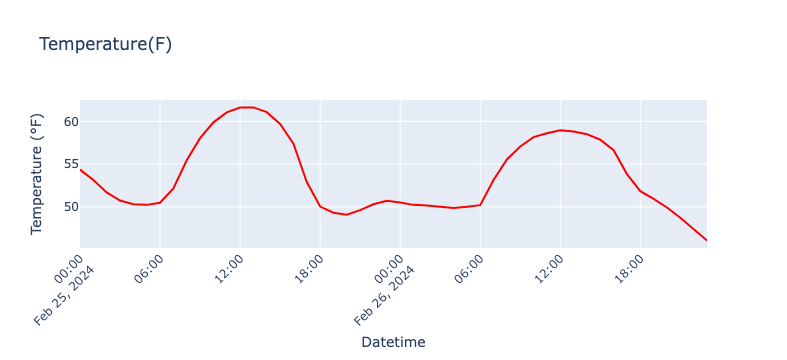

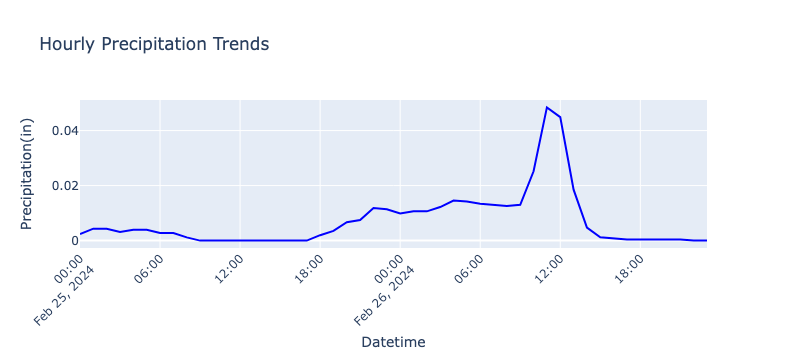

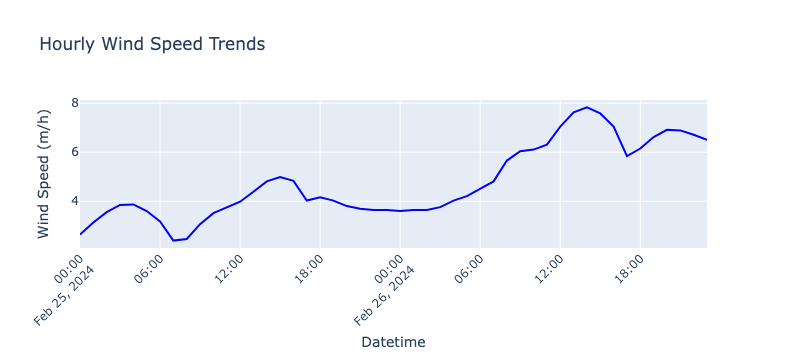

Fetching data from 20140101 to 20151231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20160101 to 20171231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20180101 to 20191231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20200101 to 20211231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194

Fetching data from 20220101 to 20231231

Hourly Weather Data for Latitude 37.7749, Longitude -122.4194



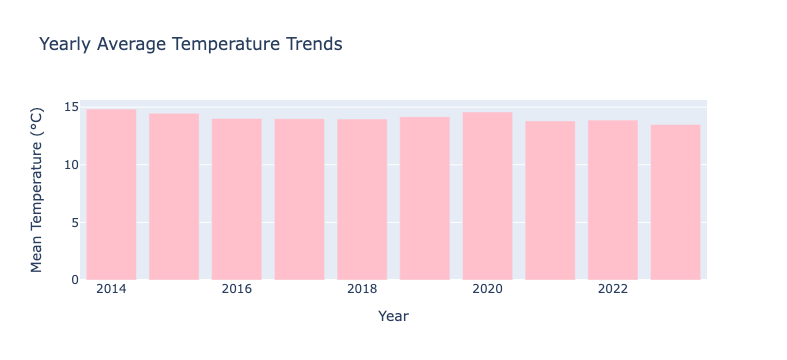

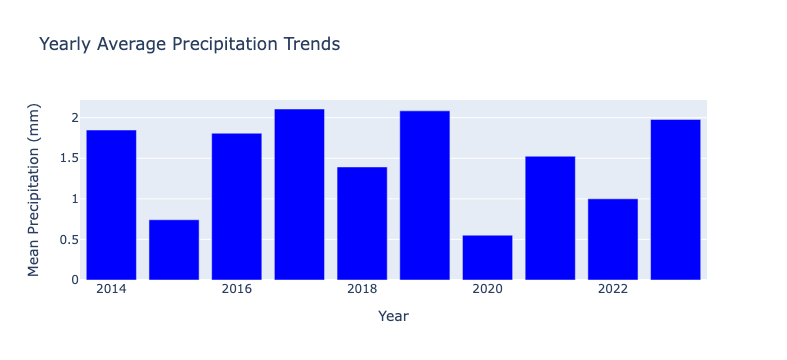

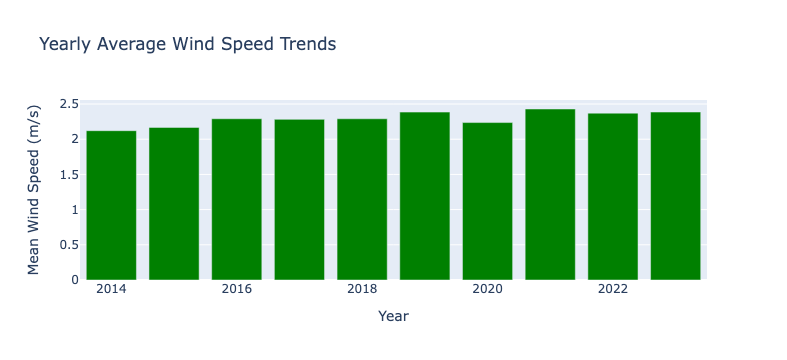


Hourly Weather Data for Latitude 37.69363021850586, Longitude -122.3651351928711


Hourly Weather Data for Latitude 37.79331588745117, Longitude -122.40015411376953


Hourly Weather Data for Latitude 37.79164123535156, Longitude -122.3748550415039


Hourly Weather Data for Latitude 37.66154098510742, Longitude -122.47383117675781


Hourly Weather Data for Latitude 37.666046142578125, Longitude -122.42002868652344


Hourly Weather Data for Latitude 37.782073974609375, Longitude -122.35770416259766


Hourly Weather Data for Latitude 37.786006927490234, Longitude -122.36307525634766


Hourly Weather Data for Latitude 37.661155700683594, Longitude -122.46488189697266


Hourly Weather Data for Latitude 37.69023132324219, Longitude -122.36915588378906


Hourly Weather Data for Latitude 37.88880920410156, Longitude -122.60521697998047


Hourly Weather Data for Latitude 37.702938079833984, Longitude -122.35606384277344


Hourly Weather Data for Latitude 37.7841796875, Longitude -122.360397338

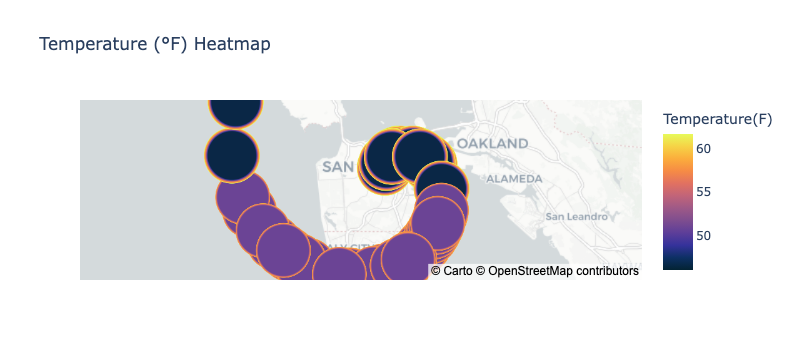

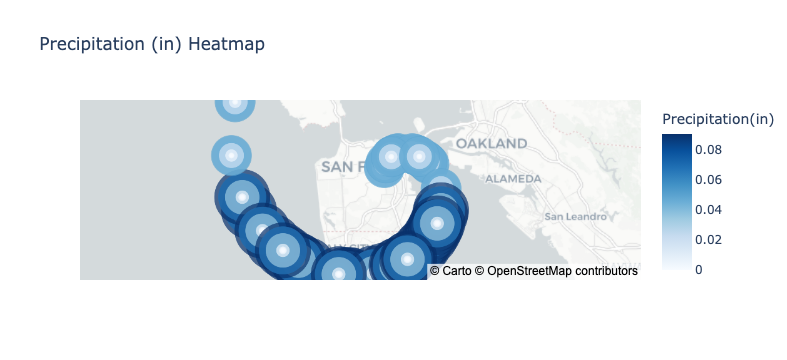

In [29]:
# Example Usage:
generate_all_visualizations(37.7749, -122.4194, "20240225", "20240226")